In [2]:
!unzip /content/drive/MyDrive/animal_image/animal_image.zip -d /content/drive/MyDrive/animal_image

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/73b10839bc.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/74dc1dd32a.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/75ab166a7d.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/79e1610d01.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/7ba5eee91f.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/7d214aab4b.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/7f2ef9ab03.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/82ec723a4f.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/85e145af6c.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/862e2c6379.jpg  
  inflating: /content/drive/MyDrive/animal_image/animals/animals/bison/87a5c700ad.jp

In [11]:
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터 경로 설정
data_dir = "/content/drive/MyDrive/animal_image/animals/animals"

# 이미지 로드 및 데이터셋 생성
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5400 files belonging to 90 classes.
Using 4320 files for training.
Found 5400 files belonging to 90 classes.
Using 1080 files for validation.


In [12]:
class_names = train_ds.class_names
print("클래스 이름:", class_names)
print("클래스 개수:", len(class_names))

클래스 이름: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
클래스 개수: 90


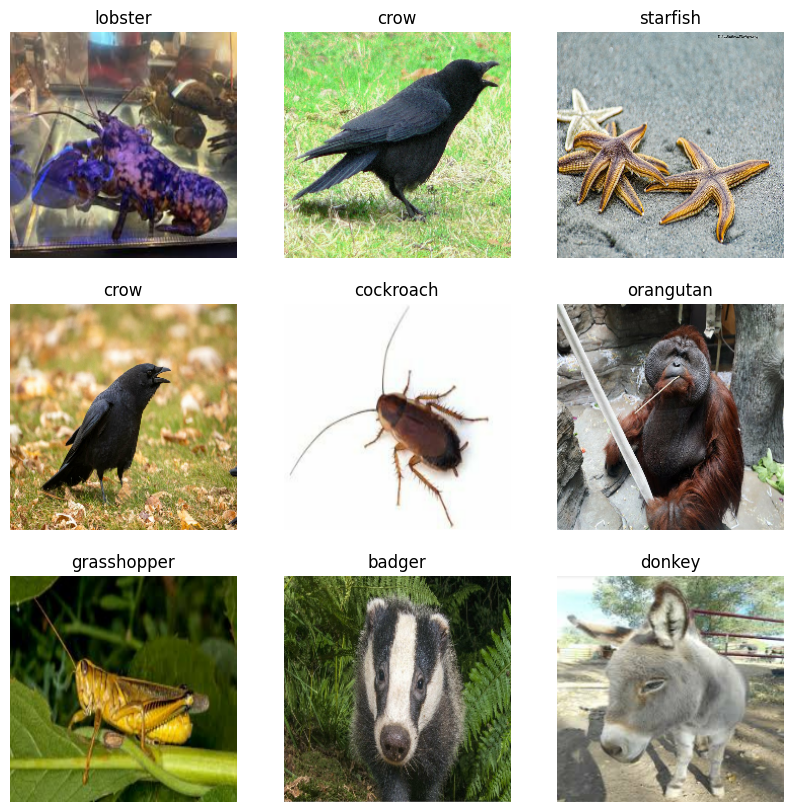

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [15]:
from tensorflow.keras import layers, Sequential

# 데이터 증강 레이어 설정
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [17]:
from tensorflow.keras.applications import EfficientNetB0

# 전처리 레이어 설정
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# EfficientNetB0 모델 불러오기 (ImageNet 가중치 사용, 최상위 분류 레이어는 제외)
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3),
                            include_top=False,
                            weights="imagenet")

# 기본 모델 고정 (가중치 업데이트 방지)
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# 전이 학습을 위한 모델 구성
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), activation="softmax")(x)
model = Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [20]:
# 모델 학습
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 554s 4s/step - accuracy: 0.3081 - loss: 3.5069 - val_accuracy: 0.8278 - val_loss: 1.1437
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 528s 4s/step - accuracy: 0.8065 - loss: 1.0845 - val_accuracy: 0.8685 - val_loss: 0.6575
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 564s 4s/step - accuracy: 0.8570 - loss: 0.6718 - val_accuracy: 0.8806 - val_loss: 0.5116
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step - accuracy: 0.9041 - loss: 0.4812 - val_accuracy: 0.8944 - val_loss: 0.4406
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 538s 4s/step - accuracy: 0.9157 - loss: 0.4077 - val_accuracy: 0.8926 - val_loss: 0.4087
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.9325 - loss: 0.3454 - val_accuracy: 0.9019 - val_loss: 0.3766
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.9441 - loss: 0.2906 - val_accuracy: 0.8981 - val_loss: 0.3591
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.9554 - loss: 0.2594 - val_accu